# TensorFlow Tutorial #02
# Convolution Neural Network
by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/) / [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction
이전 튜토리얼에서 MNIST 데이터셋에서 숫자 손글씨를 인식하는데에 단순 선형 모델은 약 91%의 분류 정확도를 보여줬다.

이 튜토리얼에서 단순한 콘볼루션 신경망을 사용해 99%의 분류 정확도를 구현할 것이다.

콘볼루션 신경망은 입력 이미지에 대해 작은 필터를 이동시키면서 작동한다. 이것은 전체 입력 이미지에 대해 패턴을 인식하기 위해 그 필터가 재사용됨을 의미한다. 이것이 같은 변수의 완전 연결 신경망보다 콘볼루션 신경망이 더 강력하게 만드는 것이다. 

기본 선형 대수, 파이썬, 주피터 노트북에 익숙하면 좋다. 텐서플로 초보자라면 이거하기 전에 첫번째 튜토리얼 학습해라

## Flowchart
아래의 그림은 콘볼루션 신경망의 데이터 흐름을 대략적으로 보여준다.

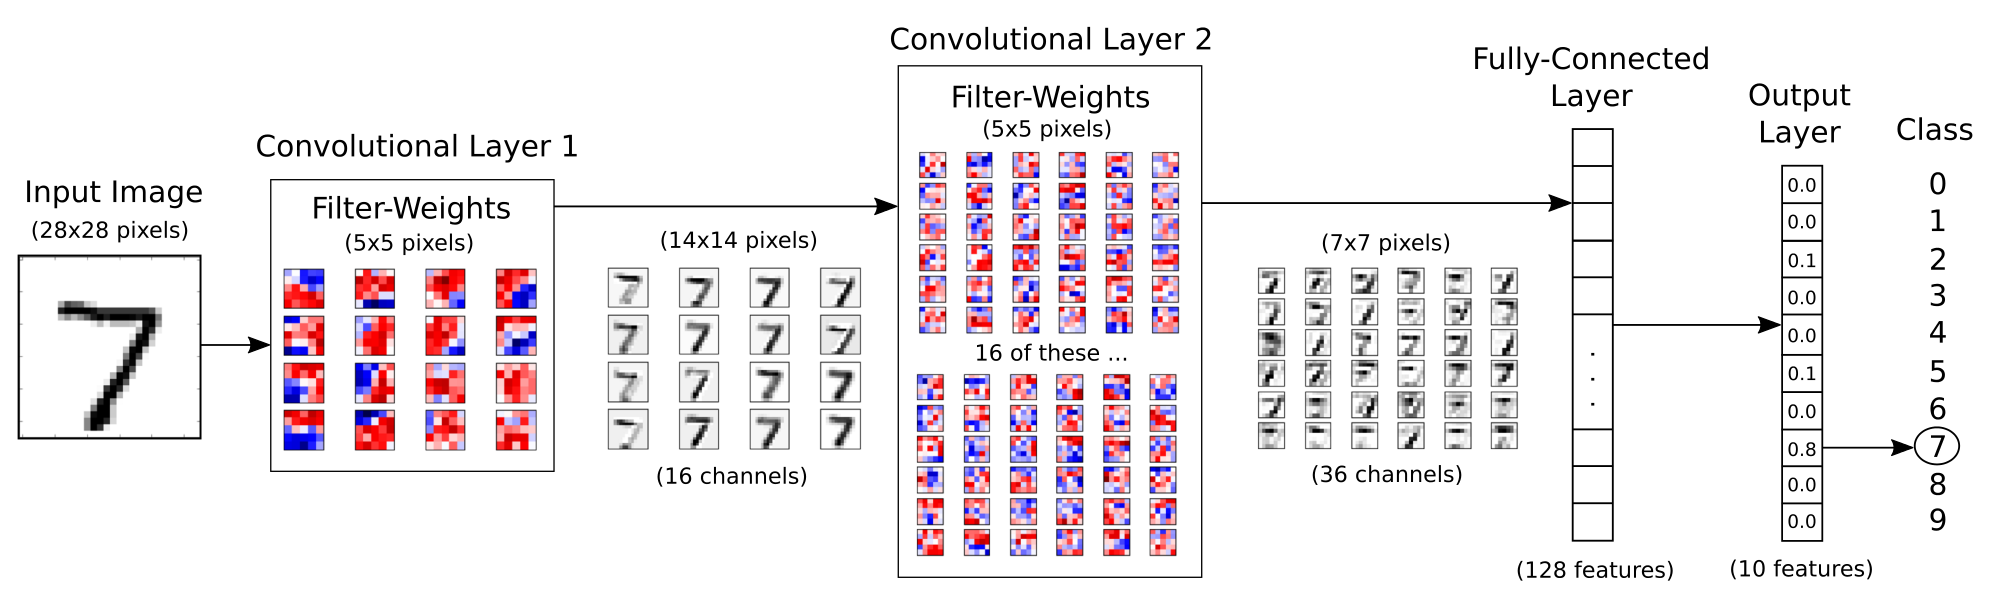

In [1]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

입력 이미지는 필터 가중치를 사용해 첫번째 콘볼루션 레이어에서 처리된다. 그 결과, 콘볼루션 레이어에서 각 필터에 대한 16개의 새로운 이미지가 된다. 이미지들은 28x28에서 14x14 로 해상도가 다운샘플링된다.

이 16개의 작은 이미지들은 2번째 콘볼루션 레이어에서 처리된다. 16개의 이미지들에 대해 36개의 필터를 적용하여, 두번째 콘볼루션 레이어에서 16 x 36 = 576 개의 필터가 된다. 결과 이미지들은 다시 7x7 로 다운 샘플링 된다.

두번째 콘볼루션 레이어의 출력은 7x7 픽셀의 36개 이미지이다. 이들은 7 x 7 x 36 = 1764의 길이를 갖는 1차원 벡터로 평탄화된다. 
이것은 128개의 뉴런을 갖는 완전 연결 레이어의 입력으로 사용된다. 이 128개의 뉴런은 다시 10개의 뉴런을 갖는 완전 연결 레이어로 연결된다. 10개의 뉴런은 각각 하나의 클래스를 의미하며, 이미지의 클래스를 결정하기 위해 사용된다.

콘볼루션 필터들은 무작위로 초기화되고, 그래서 무작위로 분류된다. 예측과 실제 클래스 사이의 오차는 크로스 엔트로피로 측정된다. 최적화기는 체인룰을 사용해 콘볼루션 레이어를 따라 역전파되고, 필터 가중치를 업데이트한다. 분류 오차가 충분히 작을 때까지 수천번 반복된다.

이들 특정 필터 가중치들과 중간 이미지들은 하나의 최적화 결과로써 만약 노트북을 다시 실행시킨다면 다른 것을 볼 수도 있다.

텐서플로에서 이 연산은 더 효율적으로 계산하기 위해 하나의 이미지 대신 하나의 배치에 대해 자동으로 된다. 텐서플로에서 구현될 때 실제로 플로우차트에는 하나 이상의 데이터 차원이 있음

## Convolutional Layer
다음 차트는 첫번째 콘볼루션 레이어에서 이미지를 처리하는 기본적인 아이디어를 보여준다. 입력 이미지는 7이고, 4장이 복사되어 있다. 그래서 우리는 필터가 어떻게 이미지의 다른 위치들을 이동하는지 명확하게 볼 수 있다. 필터의 각 위치에 대해, 필터 아래 이미지와 필터 사이의 내적으로 출력 이미지의 하나의 픽셀이 나온다. 전체 입력 이미지에 대해 필터를 이동시키면서 새로운 이미지를 생성한다.

빨간색 필터 가중치는 이 필터가 입력 이미지의 검정 픽셀에 대해 양의 반응을 갖는 것을 의미한다. 반대로 파란색 픽셀은 음의 반응을 의미한다.

이렇게 볼 때 이 필터는 출력 이미지에서 그 선에 대한 강한 반응으로부터 숫자 7의 수평 선을 인식하는 것으로 보인다. 

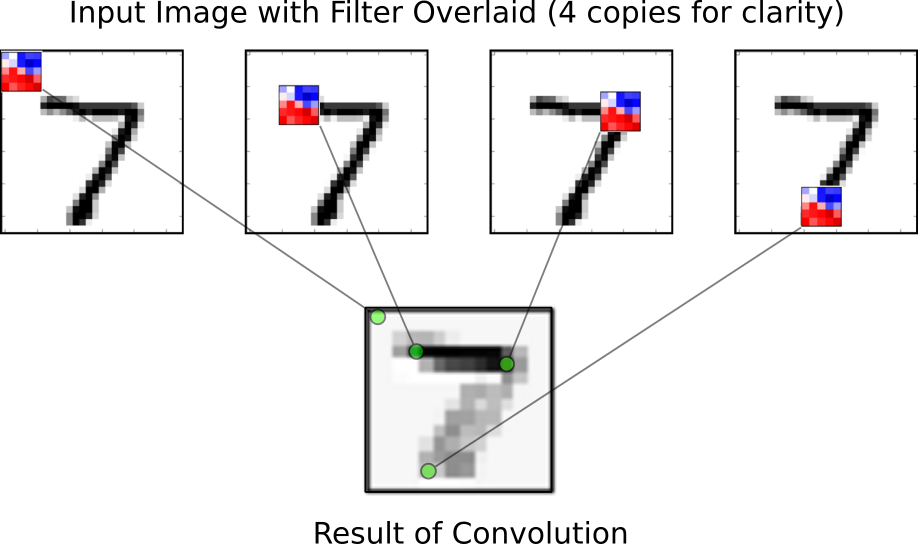

In [2]:
Image('Images/02_convolution.png')

입력에 대해 필터를 이동시킬 때의 걸음 크기를 스트라이드(stride)라 한다. 수평 x축과 수직 y 축으로 이동하는 2개의 스트라이드가 있다.

아래 소스 코드에서 스트라이드는 두 방향 모두 1로 설정했다. 이 말은 왼쪽 상단에서 필터가 시작해서 오른쪽으로 1 픽셀씩 움직인다는 것이다. 필터가 이미지의 오른쪽 끝에 도달하면, 필터는 왼쪽 끝으로 이동해 1 픽셀 아래에서 다시 이동한다. 이렇게 오른쪽 아래 모서리까지 도달하면, 전체 출력 이미지가 만들어진다.

모서리 정보까지 다 이용하고 싶으면, 0(흰 픽셀)으로 채울 수 있다. 이것은 출력 이미지가 입력 이미지와 동일한 차원을 갖게 한다.

그 다음에, 콘볼루션의 출력은 음수는 0으롤 만드는 ReLU 라고 불리는 것을 통과한다. 이 이미지는 2x2 픽셀의 작은 윈도우가 움직이면서 그들 중 가장 큰 값만 남기는 max-pooling 이라 불리는 다운 샘플링 될 수 있다. 입력 이미지의 해상도는 28x28 에서 14x14가 된다.

두번째 콘볼루션 레이어는 16개의 입력 채널을 갖기 때문에 더 복잡하다. 우리는 각 입력 채널에 대해 별도의 필터가 필요하기 때문에리는 1개 대신에 16개의 필터가 필요하다. 그리고, 두번째 콘볼루션 레이어로부터 36개의 출력 채널을 원하기 때문에 두번째 콘볼루션 레이어에 대해서 총 16 x 36 = 576 개의 필터가 필요하다. 이게 어떻게 돌아가는지 이해하는 것은 조금 어려울 수 있다

## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time # 시간 라이브ㅓ리
from datetime import timedelta # 시간 차이 계산하는 함수
import math # 수학 라이브러리

파이썬 3.5.2 (아나콘다)와 텐서플로 1.0.1 버젼으로 함

In [4]:
tf.__version__

'1.0.1'

## Configuration of Neural Network
콘볼루션 신경망의 환경설정은 편의를 위해 아래에 정의한다. 그래서 쉽게 찾을 수 있고, 값을 바꾸기 쉽다.

In [5]:
# 콘볼루션 레이어 1
filter_size1 = 5 # 콘볼루션 필터는 5 x 5 픽셀
num_filters1 = 16 # 필터의 개수는 16개

# 콘볼루션 레이어 2
filter_size2 = 5 # 콘볼루션 필터는 5 x 5 픽셀
num_filters2 = 36 # 필터의 갯수는 36개

# 완전 연결 레이어
fc_size = 128 # 완전 연결 레이어에서 뉴런의 수

## Load Data
MNIST 데이터셋은 약 12 MB 정도고, 주어진 경로에 없다면 자동으로 받아짐

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("./data/MNIST/", one_hot = True)

Extracting ./data/MNIST/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST 데이터셋은 70,000 장의 이미지와 라벨로 구성되어 있다. 
이 데이터셋은 상호 배타적인 3개로 나뉘어 있다. 
이 튜토리얼에서는 학습과 테스트만 사용할 것이다.

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


클래스 라벨들은 One-Hot encode 되어있다. 이것은 해당 라벨만 1이고 나머지는 0인 10의 길이를 갖는 벡터로 되어 있음을 의미한다. 우리는 또한 테스트 셋에 대한 비교를 위해 정수도 필요하다.

In [8]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data dimensions
데이터 차원은 아래 보이는 소스코드 여러군데에서 사용된다. 

컴퓨터프로그래밍에서 일반적으로 사용할 모든 숫자를 입력하는 하드코딩 보다는 변수나 상수를 사용하는 것이 최선이다. 

이것은 그 숫자들은 하나의 위치에서만 바꾸는 것을 의미한다. 

이상적으로 이것들은 자료에서 얻어질 것이지만, 여기서는 숫자들로 입력한다.

In [9]:
# MNIST 이미지의 각 차원은 28 픽셀이다
img_size = 28

# 이미지들은 1차원 벡터로 저장되어 있다
img_size_flat = img_size * img_size

# 높이와 너비를 갖는 튜플은 reshape 배열에 사용된다.
img_shape = (img_size, img_size)

# 이미지에 대한 색 채널의 수 : 흑백 채널은 1채널이다.
num_channels = 1

# 클래스의 숫자, 10개 숫자 각각이 하나의 클래스
num_classes = 10

## Helper-function for plotting images
3x3 격자에 9개의 이미지를 출력하고, 각 이미지에 대해 예측 클래스와 실제값을 보여주는 함수

In [10]:
# 3개의 인자를 받는다. (이미지, 실제 클래스값, 클래스 예측값)
def plot_images(images, cls_true, cls_pred=None):
    # 이미지의 길이와 cls_true의 값이 9가 맞는지 확인 아니면 에러
    assert len(images) == len(cls_true) == 9
    
    # subplots로 3x3 격자 figure를 만듬
    fig, axes = plt.subplots(3, 3)
    # 각 격자의 떨어진 정도를 조정함
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # 각 격자의 순서대로 넣기 위해 enumerate를 사용
    for i, ax in enumerate(axes.flat):
        # 이미지를 각 순서대로 넣음
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # 실제값과 예측값을 보여줌
        # 예측 클래스 값들이 없으면
        if cls_pred is None:
            # 실제값만 나타냄
            xlabel = "True: {0}".format(cls_true[i])
        # 아니면
        else:
            # 둘다 나타냄
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        # x축 라벨 설정
        ax.set_xlabel(xlabel)
        
        # 눈금 지움
        ax.set_xticks([])
        ax.set_yticks([])

## Plot a few images to see if data is correct

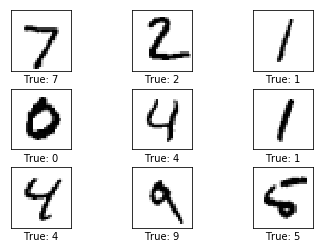

In [11]:
# 테스트셋에서 첫 9개 이미지 가져옴
images = data.test.images[0:9]

# 이들 이미지의 실제 클래스값 얻음
cls_true = data.test.cls[0:9]

# 위의 함수를 이용해 나타냄
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph
텐서플로의 목적은 파이썬에서 같은 연산을 실행하는 것보다 효율적으로 실행할 수 있는 계산 그래프(computational graph)를 갖는 것이다. 텐서플로는 넘파이가 매 순간 하나의 수식 연산만 아는 것과는 달리 실행될 때에 모든 계산 그래프를 알고 있어야하기 때문에 더 효율적이다.

텐서플로는 모델이 더 나은 성능을 내기 위해서 그래프의 변수들을 최적화하기 위해 필요한 그라디언트를 자동으로 계산할 수 있다. 이 그래프가 하나의 수식 연산의 결합이기 때문에 체인룰을 이용해 전체 그래프의 그라디언트를 계산할 수 있다.

텐서플로는 또한 멀티코어 CPU 이점도 있다.

텐서플로 그래프는 아래의 파트로 구성된다:
- Placeholder 변수는 그래프의 입력을 바꿀 때 사용
- Model 변수는 최적화될 변수
- 모델은 placeholder 변수와 model 변수들이 주어질 때 출력을 계산하는 수학 함수
- 비용은 변수의 최적화에 사용
- 최적화방법은 모델의 변수를 업데이트 하는 것

게다가, 텐서플로 그래프는 이 튜토리얼에서 다루지는 않지만, 텐서보드를 사용해 보기위한 로그를 남기기 위한 다양한 디버깅 스테이트먼트를 포함할 수 있다. 

## Helper-function for creating new variables
모양(shape)가 주어졌을 때 무작위 값으로 초기화하는 새로운 텐서플로 변수를 만드는 함수. 초기화는 실제로는 이 시점에서  이루어지지 않고, 텐서플로우 그래프에만 정의하는 것이다.

In [12]:
# 새 가중치
def new_weights(shape):
    # 모양을 받아서 표준편차 0.05 를 갖는 양의 정규분포로부터 변수를 만든다
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [13]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## Helper-function for creating a new Convolutional Layer
텐서플로의 계산 그래프 내에 새로운 콘볼루션 레이어을 만드는 함수. 여기서는 실제로 계산이 이루어지는 것은 없고, 텐서플로 그래프에 수학적 공식만 더하는 것뿐이다.
입력은 4차원 텐서로 가정한다.

1. 이미지의 수
2. 각 이미지의 Y 축
3. 각 이미지의 X 축
4. 각 이미지의 채널 수

입력 채널은 색이 있는 채널이거나, 입력이 이전 콘볼루션 레이어에서 만들어진 것이라면 필터 채널일 수도 있다.

출력은 또다른 4차원 텐서다.

1. 입력수, 입력과 동일함
2. 각 이미지의 Y 축. 만약 2x2 pooling으 사용하면, 이미지의 높이와 너비가 2로 나눠진다.
3. 각 이미지의 X 축. 위와 같다.
4. 콘볼루션 필터들에 의해 만들어진 채널 수

In [14]:
def new_conv_layer(input,              # 이전 레이어
                   num_input_channels, # 이전 레이어의 채널 수
                   filter_size,        # 각 필터의 높이와 너비
                   num_filters,        # 필터 수
                   use_pooling=True):  # 2x2 max-pooling 사용 여부

    # 콘볼루션을 필터 가중치의 모양
    # 이 포맷은 텐서플로 API에 의해 결정된다.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # 주어진 모양을 갖는 필터 가중치를 만든다.
    weights = new_weights(shape=shape)

    # 각 필터에 대한 한개의 새로운 바이어스를 만든다.
    biases = new_biases(length=num_filters)

    # 콘볼루션을 위한 텐서플로 연산을 만든다.
    # 모든 차원에서 스트라이드는 1로 설정된다.
    # 첫번째와 마지막 스트라이트는 항상 1이다
    # 왜냐하면 첫번재는 이미지의 수이고, 마지막은 입력 채널수이기 때문이다.
    # 하지만 예를 들어 strides=[1, 2, 2, 1]은 
    # 이미지의 x와 y축에 대해 2 픽셀씩 필터를 이동하는 것을 의미한다.
    # padding 을 'SAME' 으로 설정하는 것은 입력 이미지에 0 채우기를 해서 출력의 크기가 동일함을 의미한다.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # 콘볼루션의 결과에 바이어스를 더한다.
    # 바이어스의 값은 각 필터 채널에 대해 더해진다.
    layer += biases

    # 이미지 해상도를 다운 샘플링 하기 위해 pooling을 사용하는가?
    if use_pooling:
        # 2x2 max-pooling 은 2x2 윈도우를 의미하고 이 윈도우에서 가장 큰 값을 선택한다.
        # 그러면 다음 윈도우에 2 픽셀을 움직인다.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # 각 입력 픽셀 x 에 대해 max(x, 0)을 계산한다.
    # 이것은 공식에 비선형성을 추가하고, 더 복잡한 함수를 배울 수 있게 한다.
    layer = tf.nn.relu(layer)

    # ReLU는 일반적으로 pooling 전에 실행된다. 하지만 relu(max_pool(x) == max_pool(relu(xx)) 이기 때문에
    # max-pooling을 먼저함으로써 relu 연산의 75%를 줄일 수 있다.

    # 나중에 가중치를 그림 그릴 것이기 때문에 결과 레이어와 필터 가중치를 반환한다.
    return layer, weights

## Helper-function for flattenling a layer
콘볼루션 레이어는 4차원 출력 텐서를 만든다. 콘볼루션 레이어들 다음에 완전 연결 레이어를 더하기를 할 것이고, 그래서 우리는 4차원 텐서를 완전 연결 레이어에 입력으로 사용될 수 있는 2차원으로 줄일 필요가 있다.

In [15]:
def flatten_layer(layer):
    # 입력 레이어의 모양을 구한다.
    layer_shape = layer.get_shape()

    # 입력 레이어의 모양은 다음과 같이 가정된다.
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # 특징의 수는 : 이미지 높이 * 이미지 너비 * 채널 수
    # 이것을 계산할 수 있는 텐서플로 함수를 사용할 수 있다.
    num_features = layer_shape[1:4].num_elements()
    
    # 이 레이어는 [이미지의 수, 특징의 수]로 차원이 바뀐다.
    # 우리가 단순히 두번째 레이어의 크기를 num_features로 설정하고,
    # 첫번째 차원의 크기를 계산된 차원에 크기인 -1로 설정한다.
    # 그러면 이 텐서의 총 크기는 바뀌지 않는다.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # 평탄화 레이어의 모양은 이제:
    # [num_images, img_height * img_width * num_channels]

    # 평탄화 레이어와 특징의 수를 반환한다.
    return layer_flat, num_features

## Helper-function for creating a new Fully-Connected Layer
이 함수는 계산 그래프 내에 새로운 완전 연결 레이어를 만든다. 여기서는 실제로 계산이 되지는 않고, 단지 텐서플로 그래프에 수학 공식만 추가한다.

입력은 [num_images, num_inputs] 모양의 2차원 텐서로 가정한다. 출력은 [num_images, num_outputs] 모양의 2차원 텐서다.

In [16]:
def new_fc_layer(input,          # 이전 레이어
                 num_inputs,     # 이전 레이어의 입력 수
                 num_outputs,    # 출력 수
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # 새로운 가중치와 바이어스를 만든다.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # 입력과 가중치의 행렬곱을 하고 바이어스를 더하는 계산을 만든다.
    layer = tf.matmul(input, weights) + biases

    # ReLU 사용 여부
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

## Placeholder variables
Placeholder 변수는 그래프를 실행할 때 바뀔 수도 있는 그래프에 입력값을 보낸다.
아래에서 시연한다.

첫째, 입력 이미지에 대한 placeholder 변수를 정의한다. 텐서 그래프에 입력으로 변할 수 잇는 이미지를 보낸다. 이것이 다차원 벡터 혹은 행렬을 의미하는 텐서다. 데이터 타입은 float32 이고 모양은 [None, img_size_flat] 이다. None 은 정해지지 않았음을 의미한다. 각 이미지는 항상 img_size_flat의 길이를 갖는다.

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

콘볼루션 레이어들은 4차원 텐서를 입력 x 로 기대한다. 그래서 우리는 [num_images, img_size_flat] 대신에 [num_images, img_height, img_width, num_channels]의 모양을 갖도록 변형해야하낟. img_height == img_width == img_size 이고 num_images 는 첫번째 차원에 -1을 사용해 자동으로 계산하게 할 수 있다. 그래서 이미지로 변경하는 연산은 다음과 같다.

In [18]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

다음으로 입력 이미지에 해당하는 실제 라벨의 placeholder를 만든다. 이 placeholder 변수의 모양은 [None, num_classes] 이다. None은 미정이고, num_classes 는 여기서는 10이다.

In [19]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

마지막으로, 각 이미지에 해당하는 클래스를 적어둔 라벨을 만든다. 정수

In [20]:
y_true_cls = tf.argmax(y_true, dimension=1)

## Convolutional Layer 1
첫번째 콘볼루션 레이어를 만들자. x_image를 입력으로 받고, 높이와 너비가 filter_size1과 동일한 num_filters1 개의 서로다른 필터들을 만든다. 마지막으로 2x2 max-pooling을 사용해 이미지의 크기를 절반으로 줄인다.

In [21]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

콘볼루션 레이어의 출력이 될 텐서의 모양을 확인하자. (?, 14, 14, 16)은 필터들 각각에 대해 하나의 채널인 16개의 서로다른 채널들과 높이와 너비 모두 14 픽셀인 변경 가능한 이미지의 수를 갖음을 의미한다.

In [22]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

## Convolutional Layer 2
첫번째 콘볼루션 레이어의 출력을 입력으로 갖는 두번째 콘볼루션 레이어를 만들자. 입력 채널의 수는 첫번째 콘볼루션 레이어의 필터의 갯수와 같다.

In [23]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

콘볼루션 레이어의 출력이 될 텐서의 모양을 확인하자. (?, 7, 7, 36)은 필터들 각각에 대해 하나의 채널인 16개의 서로다른 채널들과 높이와 너비 모두 14 픽셀인 변경 가능한 이미지의 수를 갖음을 의미한다.

## Flatten Layer
콘볼루션 레이어들은 4차원 텐서를 출력한다. 우리는 이 출력을 완전 연결 레이어에 입력으로 사용하기 위해, 4차원 텐서를 2차원 텐서로 재형성할 필요가 있다.

In [24]:
layer_flat, num_features = flatten_layer(layer_conv2)

(?, 1794)는 1764 개의 길이를 갖는 픽셀과 변경 가능한 이미지 수를 의미한다. 1764 = 7 x 7 x 36.

In [25]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [26]:
num_features

1764

## Fully-Connected Layer 1
신경망에 완전 연결 레이어를 추가하자. 입력은 이전 콘볼루션으로부터의 평탄화된 레이어다. 완전 연결 레이어의 뉴런의 수는 fc_size 다. ReLU가 사용된다. 그래서 우리는 비선형 관계를 학습할 수 있다.

In [27]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

이 완전 연결 레이어의 출력이 (?, 128) 모양의 텐서임을 확인하자. ?는 변경 가능한 이미지의 수고, fc_size == 128 이다.

In [28]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

## Fully-Connected Layer 2
입력 이미지의 10 클래스를 결정하기 위한 길이 10의 벡터를 출력하는 완전 연결 레이어를 추가하자. 이 레이어에서 ReLU는 사용되지 않는다.

In [29]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [30]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

## Predicted Class
두번째 완전 연결 레이어는 이미지가 10개의 클래스 각각에 속하는지를 측정한다. 하지만, 이 추정치는 조금 거칠고 해석하기 어렵다. 왜냐하면 이 숫자들은 너무 작거나 클 수 있어서, 우리는 이들을 0에서 1 사이로 정규화하고 싶어한다.  softmax 함수를 사용해 계산되고, 이 결과는 y_pred에 저장된다.

In [31]:
y_pred = tf.nn.softmax(layer_fc2)

이 예측된 클래스는 각 행의 가장 큰 요소의 인덱스이다.

In [32]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost-function to be optimized
입력 이미지를 분류하는데에 더 나은 모델을 만들기 위해, 우리는 모든 신경망 레이어의 변수들을 바꿔야만 한다. 이를 위해 우리는 y_pred와 바람직한 실제 출력 y_true를 비교함으로써 현재 모델의 성능이 얼마인지 알아야할 필요가 있다.

크로스엔트로피는 분류에서의 성능 측정 지표이다. 크로스엔트로피는 항상 양의 값을 갖는 연속함수이고, 실제와 예측이 정확히 일치하면 0을 갖는다. 그러므로, 최적화의 목표는 네트워크 레이어의 변수들을 바꿔감으로써 가능한한 0에 가깝게 크로스엔트로피를 최소화하는 것이다.

텐서플로는 크로스엔트로피를 계산하기 위한 내장함수가 있다. 다만, 이것은 내부적으로 소프트맥스를 하기 때문에 y_pred 대신에 layer_fc2를 사용해야한다.

In [33]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

이제 우리는 각 이미지에 대한 크로스엔트로피를 계산할 수 있다. 하지만, 크로스엔트로피를 최적화하는데 사용하기 위해서는 하나의 숫자가 되어야한다. 그래서 우리는 모든 이미지 분류에 대한 크로스엔트로피를 평균한다.

In [34]:
cost = tf.reduce_mean(cross_entropy)

## Optimiztation method
이제 비용 함수를 최소화해줄 최적화기(optimizer)를 만들 수 있다. 여기서는 기울기 강하의 진화된 형태인 AdamOptimizer를 사용한다.

이 시점에서 최적화는 아무것도 수행되지 않는다. 사실, 아무것도 전혀 계산되지 않는다. 단지 나중에 실행될 최적화기 객체를 텐서플로 그래프에 더한 것 뿐이다.

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance measures
사용자에게 진행사항을 나타내기 위한 성능 지표가 필요하다.
이미지의 예측 클래스 값이 실제 클래스 값과 일치하는지 아닌지에 대한 진리값(boolean) 벡터이다.

In [36]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

이건 분류 정확도를 계산한다. 이건 진리값 벡터기 때문에 float 형으로 바꿔서 False는 0으로 True는 1로 바꾼 후에 평균한다.

In [37]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run
## Create TensorFlow session
텐서플로 그래프를 만들면, 그래프를 실행하는데 사용되는 Session을 만들어야한다.

In [38]:
# gpu 에러를 방지
config = tf.ConfigProto(
        device_count={'GPU': 0}  # uncomment this line to force CPU
    )
session = tf.Session(config=config)

## Initialize variables
weights 와 biases의 변수들은 최적화 전에 초기화되어야만 한다.

In [39]:
session.run(tf.global_variables_initializer())

## Helper-function to perform optimization iterations
학습 데이터셋에 5만5천개 이미지가 있다. 모든 이미지를 사용해 그라디언트를 계산하는데에는 너무 오래걸린다. 그래서 매 반복마다 이미지의 표본을 사용하는 확률적 기울기 강하(Stochastic Gradient Descent)를 사용한다.

만약 컴퓨터가 RAM 때문에 너무 느리거나 멈추면, 더 작은 수를 시도해라.

In [40]:
train_batch_size = 64

weights와 biases를 점진적으로 향상시키기 위한 최적화를 수행하는 함수. 각 반복에서, 데이터의 새로운 표본이 선택되고, 텐서플로는 그 학습 표본들을 사용해 최적화기를 실행한다. 진행은 매 100번 반복마다 표시한다.

In [41]:
# 지금까지 수행된 반복 총 횟수 세기
total_iterations = 0

# 반복횟수를 인자로 받는다
def optimize(num_iterations):
    # 지역 변수보다 전역 변수를 바꾸는 걸 보장한다
    global total_iterations
    
    # 아래에 사용된 시간을 나타내는 start_time
    start_time = time.time()
    
    # 반복횟수동안 반복
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        # 학습 데이터의 표본을 얻는다.
        # x_batch는 이미지의 표본을 가지고 있고,
        # y_true_batch는 이들 이미지에 대한 실제 라벨을 갖고 있다.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        # 텐서플로 그래프에서 placeholder 변수의 이름을 갖는 사전속에 표본을 넣는다.
        # y_true_cls placeholder 에 대해서는 설정하지 않는다. 왜냐하면 이것은 학습동안 사용되지 않기 때문이다.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 학습 자료의 이 표본을 사용해 최적화기를 실행한다.
        # 텐서플로는 feed_dict_train에 있는 변수들을 placeholder 변수에 할당하고 실행한다.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # 100번 반복마다 상태를 표시한다.
        if i % 100 == 0:
            # 학습 데이터셋에 대한 정확도 계산
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            # 출력할 메시지
            msg = "최적화 반복: {0:>6}, 학습 정확도: {1:>6.1%}"
            
            # 출력
            print(msg.format(i + 1, acc))
    
    # 수행된 총 반복 횟수 업데이트
    total_iterations += num_iterations
    
    # 끝난 시간
    end_time = time.time()
    
    # 시작과 끝 시간 차이
    time_dif = end_time - start_time
    
    # 사용 시간 출력
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Helper-function to plot example errors
잘못 분류된 테스트셋의 이미지를 표시하는 함수

In [42]:
def plot_example_errors(cls_pred, correct):
    # 이 함수는 print_test_accuracy() 로부터 불러와진다.
    # cls_pred는 테스트 셋에 모든 이미지에 대한 예측된 클래스의 배열
    
    # correct 는 테스트 셋에 모든 이미지에 대한 실제와 예측의 진리값
    
    # 잘못 분류된 인덱스를 얻는다
    incorrect = (correct == False)
    
    # 올바르게 분류되지 않은 이미지를 얻는다
    images = data.test.images[incorrect]
    
    # 이들 이미지의 예측 클래스를 얻는다
    cls_pred = cls_pred[incorrect]

    # 이들 이미지의 실제 클래스를 얻는다.
    cls_true = data.test.cls[incorrect]
    
    # 9개의 이미지를 나타낸다.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## Helper-function to plot confusion matrix

In [43]:
def plot_confusion_matrix(cls_pred):
    # 이 함수는 아래의 print_test_accuracy() 로부터 호출된다.
    
    # cls_pred는 테스트 셋에 모든 이미지에 대한 예측된 클래스의 배열
    
    # 테스트셋에 대한 실제 분류를 얻는다
    cls_true = data.test.cls
    
    # sklearn을 이용해 혼동 행렬을 얻는다.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # 혼동행렬을 텍스트로써 출력한다.
    print(cm)

    # 이미지로서 혼동 행렬을 표시한다.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # 도표에 대해 다양한 조정을 한다.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

## Helper-functions to show performance
테스트 셋에 대한 분류 정확도를 출력하는 함수

테스트 셋에 모든 이미지에 대한 분류를 계산한다. 결과는 이 함수로부터 직접적으로 위의 함수에 호출되어 재사용된다. 그래서 분류는 각 함수마다 재 계산되지 않는다.

이 함수는 컴퓨터 메모리를 많이 사용할 수 있으므로 테스트 셋을 작은 배치로 만드는 이유이다. 컴퓨터에 RAM 이 거의 없고 충돌나면, 더 작은 수의 배치를 사용할 수 있다.

In [44]:
# 테스트셋을 작은 사이즈의 배치로 나눈다.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # 테스트셋의 이미지의 수
    num_test = len(data.test.images)

    # 배치에서 계산되기 위한 예측 클래스의 배열을 할당하고 이 배열 속에 채운다.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # 배치에 대해 예측 클래스를 계산한다.
    # 모든 배치에 대해 반복할 것

    # 배치를 위한 순번 초기화
    i = 0
    
    # i가 테스트셋 숫자보다 작은 경우 계속
    while i < num_test:
        # j 는 배치의 끝 번호
        j = min(i + test_batch_size, num_test)

        # i부터 j까지 이미지 꺼내오기
        images = data.test.images[i:j, :]

        # i부터 j까지 라벨 꺼내오기
        labels = data.test.labels[i:j, :]

        # 이미지와 라벨을 feed_dict 으로 만든다
        feed_dict = {x: images,
                     y_true: labels}

        # 텐서플로를 사용해 예상 클래스를 만든다
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # 다음 배치를 위해 i를 j로 바꾼다
        i = j

    # 테스트 셋의 실제 클래스를 모은다.
    cls_true = data.test.cls

    # 예상 클래스와 실제 클래스르 비교한다.
    correct = (cls_true == cls_pred)

    # 맞은 수를 센다
    correct_sum = correct.sum()

    # 맞은 수를 전체 수로 나눠서 정확도를 계산한다.
    acc = float(correct_sum) / num_test

    # 정확도 표시
    msg = "테스트 셋에 대한 정확도: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # 원한다면 틀린 그림을 표시할 수 있다
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # 원한다면 혼동 행렬을 표시할 수 있다
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization
테스트 셋에 대한 정확도는 매우 낮다 왜냐하면 초기화만되고 최적화되지 않았기 때문이다 그래서 이미지는 무작위로 분류되었다.

In [45]:
print_test_accuracy()

테스트 셋에 대한 정확도: 10.0% (996 / 10000)


## Performance after 1 optimization iteration
1번 최적화 이후 정확도는 별로 증가하지 않았다. 왜냐하면 최적화방법에 대한 학습률이 매우 낮게 설정되었기 때문이다.

In [46]:
optimize(num_iterations=1)

최적화 반복:      1, 학습 정확도:  10.9%
Time usage: 0:00:00


In [47]:
print_test_accuracy()

테스트 셋에 대한 정확도: 10.5% (1049 / 10000)


## Performance after 100 optimization iterations
100번 최적화 반복 이후, 이 모델은 분류 정확도가 유의미하게 향상되었다.

In [48]:
optimize(num_iterations=99) # 이미 우린 한번 반복함

Time usage: 0:00:05


테스트 셋에 대한 정확도: 68.7% (6865 / 10000)
Example errors:


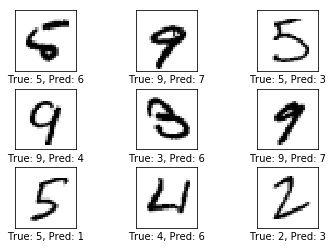

In [49]:
print_test_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations
1000번 반복 이후, 90% 이상 테스트셋에 대한 정확도가 증가했다.

In [50]:
optimize(num_iterations=900) # 이미 우리는 100번 반복함

최적화 반복:    101, 학습 정확도:  73.4%
최적화 반복:    201, 학습 정확도:  73.4%
최적화 반복:    301, 학습 정확도:  75.0%
최적화 반복:    401, 학습 정확도:  89.1%
최적화 반복:    501, 학습 정확도:  87.5%
최적화 반복:    601, 학습 정확도:  95.3%
최적화 반복:    701, 학습 정확도:  90.6%
최적화 반복:    801, 학습 정확도:  92.2%
최적화 반복:    901, 학습 정확도:  90.6%
Time usage: 0:00:45


테스트 셋에 대한 정확도: 92.3% (9233 / 10000)
Example errors:


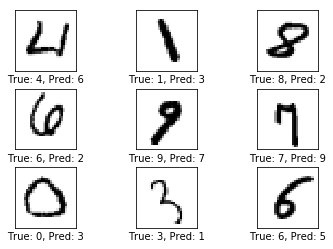

In [51]:
print_test_accuracy(show_example_errors=True)

## Performance after 10,000 optimization iterations

10,000 번 최적화 반복 이후, 약 99% 이상의 정확도를 보인다.

In [52]:
optimize(num_iterations=9000) # 이미 우리는 1000번 반복함

최적화 반복:   1001, 학습 정확도:  95.3%
최적화 반복:   1101, 학습 정확도:  92.2%
최적화 반복:   1201, 학습 정확도:  95.3%
최적화 반복:   1301, 학습 정확도:  90.6%
최적화 반복:   1401, 학습 정확도:  93.8%
최적화 반복:   1501, 학습 정확도:  96.9%
최적화 반복:   1601, 학습 정확도:  89.1%
최적화 반복:   1701, 학습 정확도:  95.3%
최적화 반복:   1801, 학습 정확도:  96.9%
최적화 반복:   1901, 학습 정확도:  93.8%
최적화 반복:   2001, 학습 정확도: 100.0%
최적화 반복:   2101, 학습 정확도:  96.9%
최적화 반복:   2201, 학습 정확도:  92.2%
최적화 반복:   2301, 학습 정확도:  95.3%
최적화 반복:   2401, 학습 정확도:  96.9%
최적화 반복:   2501, 학습 정확도:  96.9%
최적화 반복:   2601, 학습 정확도:  98.4%
최적화 반복:   2701, 학습 정확도:  93.8%
최적화 반복:   2801, 학습 정확도:  92.2%
최적화 반복:   2901, 학습 정확도:  95.3%
최적화 반복:   3001, 학습 정확도:  95.3%
최적화 반복:   3101, 학습 정확도:  95.3%
최적화 반복:   3201, 학습 정확도:  96.9%
최적화 반복:   3301, 학습 정확도:  93.8%
최적화 반복:   3401, 학습 정확도: 100.0%
최적화 반복:   3501, 학습 정확도: 100.0%
최적화 반복:   3601, 학습 정확도:  98.4%
최적화 반복:   3701, 학습 정확도:  98.4%
최적화 반복:   3801, 학습 정확도:  95.3%
최적화 반복:   3901, 학습 정확도: 100.0%
최적화 반복:   4001, 학습 정확도:  98.4%
최적화 반복:   4101, 학습 정확도:  98.4%
최적화 반복: 

테스트 셋에 대한 정확도: 98.7% (9872 / 10000)
Example errors:
Confusion Matrix:
[[ 972    0    0    0    0    3    2    1    2    0]
 [   0 1129    3    0    0    0    1    2    0    0]
 [   1    1 1024    1    1    0    0    3    1    0]
 [   0    0    0 1008    0    0    0    1    1    0]
 [   0    0    0    0  975    0    0    2    0    5]
 [   2    1    0    8    0  876    1    1    0    3]
 [   6    3    0    1    1    6  940    0    1    0]
 [   0    1    6    2    0    0    0 1016    1    2]
 [   3    0    4    8    2    3    0    3  944    7]
 [   0    4    0    4    6    2    0    3    2  988]]


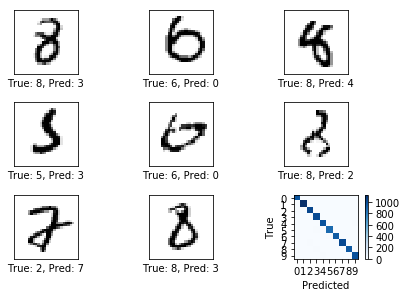

In [53]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Visualization of Weights and Layers
왜 콘불루션 신경망이 손글씨 숫자를 인식할 수 있는지 이해하기 위해 출력 이미지와 콘볼루션 필터의 가중치를 시각화한다.

## Helper-function for plotting convolutional weights

In [54]:
def plot_conv_weights(weights, input_channel=0):
    # 가중치는 4차원 텐서들에 대한 텐서플로 연산으로 가정한다.
    # e.g. weights_conv1 or weights_conv2.
        
    # 텐서플로로부터 가중치 변수의 값들을 가져온다.
    # 계산이 없기 때문에 feed_dict 은 필요없다.
    w = session.run(weights)

    # 가중치의 최소값, 최대값을 가져온다
    # 이미지에 대한 색 강도를 조정하기 위해 사용되고,  그래서 그들 각각을 비교가능하다.
    w_min = np.min(w)
    w_max = np.max(w)

    # 콘볼루션 레이어에서 사용된 필터의 수
    num_filters = w.shape[3]

    # 도표로 그리기 위해 격자로 만든다.
    # 필터의 수의 제곱근을 구하고 올림한다.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # 필터 갯수 만큼 서브플랏을 만든다
    fig, axes = plt.subplots(num_grids, num_grids)

    # 모든 가중치를 그린다
    for i, ax in enumerate(axes.flat):
        # 유효한 필터 가중치만 표시한다
        if i<num_filters:
            # 입력 채널의 i번째 필터에 대한 가중치를 얻는다
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # 눈금을 지운다.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # 하나의 노트북 셀에서 모든 도표를 나타낸다.
    plt.show()

## Helper-function for plotting the output of a convolutional layer

In [55]:
def plot_conv_layer(layer, image):
    # layer는 콘볼루션 레이어의 출력인 4차원 텐서를 출력하는 텐서플로 연산으로 가정한다.
    # e.g. layer_conv1 or layer_conv2.
    
    # 하나의 이미지만을 포함하는 feed_dict을 만든다.
    # 여기서 y_true는 필요없다 왜냐하면 계산하지 않기 때문이다.
    feed_dict = {x: [image]}

    # 입력 이미지에 대한 layer의 출력을 구한다.
    values = session.run(layer, feed_dict=feed_dict)

    # 콘볼루션 레이어에서 사용된 필터의 수
    num_filters = values.shape[3]

    # 도표로 그리기 위해 격자로 만든다.
    # 필터의 수의 제곱근을 구하고 올림한다.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # 필터 갯수 만큼 서브플랏을 만든다
    fig, axes = plt.subplots(num_grids, num_grids)

    # 모든 필터에 대한 출력 이미지를 그린다
    for i, ax in enumerate(axes.flat):
        # 유효한 필터들에 대해서만 그린다
        if i<num_filters:
            # i번째 필터를 사용한 출력 이미지를 얻는다.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # 눈금 지운다
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

## Input Images
이미지 그리기를 도와주는 함수

In [56]:
def plot_image(image):
    # 이미지를 모양대로 바꾼다
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

예제로 사용될 테스트 셋의 이미지를 그린다.

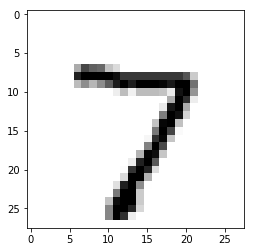

In [57]:
image1 = data.test.images[0]
plot_image(image1)

테스트 셋의 다른 이미지 그린다.

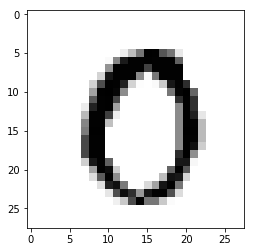

In [58]:
image2 = data.test.images[13]
plot_image(image2)

## Convolution Layer 1
첫번째 콘볼루션 레이어에 대한 필터 가중치를 그린다.
양의 가중치는 빨강이고 음의 가중치는 파랑이다.

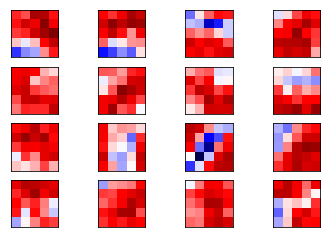

In [59]:
plot_conv_weights(weights=weights_conv1)

첫번째 입력 이미지에 대해 이들 콘볼루션 필터 각각을 적용해 얻는 출력 이미지이다. 두번째 콘볼루션 레이어에 입력으로 사용된다. 이들 이미지는 원래 이미지에서 해상도가 절반을 줄어드는 2x2 max-pooling 되어있다.

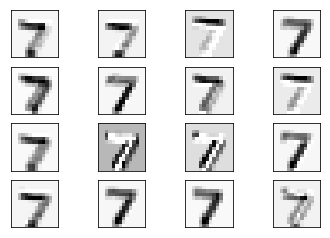

In [60]:
plot_conv_layer(layer=layer_conv1, image=image1)

두번째 이미지에 대해 콘볼루션 필터들을 적용해 얻은 결과

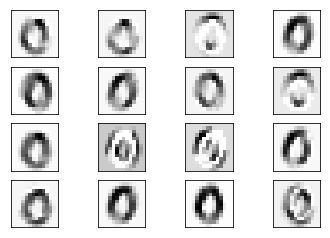

In [61]:
plot_conv_layer(layer=layer_conv1, image=image2)

이런 이미지들은 콘볼루션 필터의 목적이 무엇인지 보기 어렵다.
이것은 입력 이미지에 대해 다른 각도에서 빛이 빛추는 것처럼 입력 이미지의 여러 변화를 만들었을 뿐이다.

## Convolution Layer 2
두번째 콘볼루션 레이어에 대한 필터 가중치 그려보자.

첫번째 콘볼루션 레이어로부터 16개 출력 채널들이 두번째 콘볼루션 레이어의 입력이다. 두번째 콘볼루션 레이어는 각 입력 채널들에 대한 필터 가중치의 집합이다. 우리는 첫번째 채널에 대한 필ㄹ터 가중치를 그리는 것으로 시작한다.

양의 가중치는 빨강이고 음의 가중치는 파랑이다.

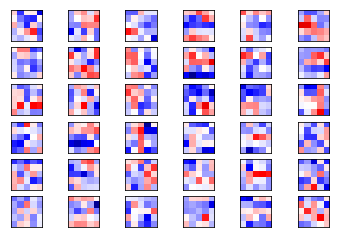

In [62]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

두번째 콘볼루션 레이어에는 입력 채널이 16개 있으므로, 이와 같은 가중치들을 15개 더 만들 수 있다.
하나 더 만들어 보자

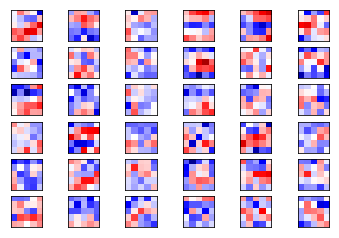

In [63]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

높은 차원 때문에 이들 필터가 어떻게 적용되는지 이해하는 것은 어려울 수 있다.
다음 이미지들은 첫번째 콘볼루션 레이어의 출력인 이미지들에 대해 이들 콘볼루션 필터를 적용한 것이다.
첫번째 콘볼루션 레이어의 이미지들의 해상도의 절반이다.

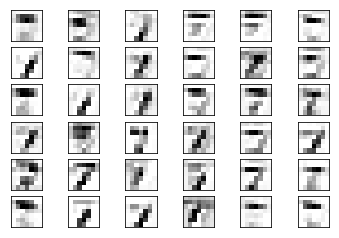

In [64]:
plot_conv_layer(layer=layer_conv2, image=image1)

두번째 이미지에 대해 필터들을 적용해본다.

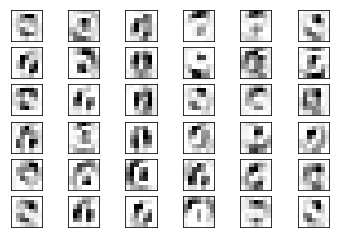

In [65]:
plot_conv_layer(layer=layer_conv2, image=image2)

이들 이미지들로부터, 두번째 콘볼루션 레이어는 첫 입력 이미지에서 지역적 변화에 덜 민감한 선을 찾거나 입력 이미지에서의 패턴을 찾는 것처럼 보인다.
이들 이미지는 평탄화되고, 완전 연결 레이어에 입력되지만, 여기서 표시하진 않는다.

## Close TensorFlow Session
텐서플로 사용을 마쳤고, 리소스를 풀기 위해 세션을 닫는다.

In [66]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion
우리는 콘볼루션 신경망이 단순 선형 모델보다 손글씨 인식에서 더 좋게 작동하는 것을 보았다. 콘볼루션 망은 선형 모델의 91% 정확도와 비교되는 약 99%의 분류 정확도를 갖는다. 

그러나 콘볼루션 신경망은 구현이 더 복잡하고, 필터가중치가 왜 작동하고 왜 종종 실패하는지 보기 어렵다.

그래서 우리는 콘볼루션 신경망을 더 쉽게 프로그래밍 하는 법과 내부 작동을 시각화하는 더 좋은 방법을 원한다.

## Exercises
텐서플로 스킬을 향상시키는데 도움이 될만한 몇가지 연습문제를 제안한다. 손으로 해보는게 중요하다.

- 어떤 파라미터의 변화 없이도 노트북을 여러번 돌려서 같은 결과를 얻을 수 있는가? 무작위성의 원인은 무엇인가?
- 다시 10,000 번 돌려라. 결과가 더 나은가?
- 최적화기에 대한 학습률을 바꿔라.
- 콘볼루션 필터의 갯수, 필터의 크기, 완전 연결 레이어의 뉴런 수 등 레이어들의 설정을 바꿔라.
- 완전연결 레이어 뒤에 드랍아웃 레이어라 불리는 것을 추가하자. 드랍아웃 확률은 분류 정확도 계산할 때는 0이어야만 하고, 그래서 이 확률은 placeholder 변수여야한다.
- 콘볼루션 레이어에서 ReLU와 max-pooling의 순서를 바꿔라. 같은 결과를 얻는가? 무엇이 가장 빠른 방법인가? 얼마나 많은 계산이 절약되는가? Sigmoid 함수와 average-pooling에도 적용되는가?
- 하나나 그 이상의 콘볼루션과 완전연결 레이어를 더하라. 성능이 향상되는가?
- 여전히 좋은 결과를 주는 가장 작은 가능한 변화는 무엇인가?
- 마지막 완전 연결 레이어에 ReLU를 시도하자. 성능이 변하는가? 왜 변하는가?
- 콘볼루션 레이어에서 풀링을 사용하지 말자. 분류 정확도와 학습 시간이 변하는가?
- max-pooling 대신에 콘볼루션에서 2x2 stride를 사용하자. 무엇이 다른가?
- 이 소스코드를 너무 많이 보지 말고 스스로 프로그램을 다시 작성해보라.
- 이 프로그램이 어떻게 작동하는지 친구에게 설명하라.

## License (MIT)
Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.